<a href="https://colab.research.google.com/github/ftkbyond77/deep-kaggle/blob/main/MobilenetV2_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
puneet6060_intel_image_classification_path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Data source import complete.')


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as T
from torchvision import datasets, models
from torch.utils.data import DataLoader

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
base_path = '../input/intel-image-classification'
train_root = os.path.join(base_path, 'seg_train', 'seg_train')
test_root = os.path.join(base_path, 'seg_test', 'seg_test')

In [ ]:
config = {
    "img_size": (64, 64),
    "batch_size": 64,
    "lr": 1e-4,
    "epochs": 10,
    "num_classes":6,
    "patience":3,
}

In [ ]:
augmented_t = T.Compose([
    T.Resize(config['img_size']),
    T.RandomHorizontalFlip(),
    T.RandomAffine(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
full_dataset = datasets.ImageFolder(train_root, transform=augmented_t)
test_dataset = datasets.ImageFolder(test_root, transform=augmented_t)

In [ ]:
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(full_dataset, test_size=0.3, random_state=42)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

len(train_loader), len(val_loader), len(test_loader)

(154, 66, 47)

In [ ]:
model = models.mobilenet_v2(pretrained=True)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
num_classes = config['num_classes']
model.classifier[1] = nn.Linear(model.classifier[1].in_features, config["num_classes"])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=config['patience'], factor=0.5, verbose=True)

In [ ]:
from collections import defaultdict

In [ ]:
loss_history = {'train': [], 'val': []}

In [ ]:
from tqdm import tqdm

In [ ]:
for epoch in range(config["epochs"]):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}") as pbar:
        for images, labels in pbar:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix(loss=running_loss/len(train_loader), accuracy=100*correct/total)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy}%")

    scheduler.step(val_loss/len(val_loader))

Epoch 1/10: 100%|██████████| 154/154 [01:10<00:00,  2.19it/s, accuracy=77.2, loss=0.633]


Validation Loss: 0.3950273889032277, Validation Accuracy: 85.89408691522203%


Epoch 2/10: 100%|██████████| 154/154 [01:09<00:00,  2.21it/s, accuracy=89.1, loss=0.309]


Validation Loss: 0.3384469004743027, Validation Accuracy: 88.12633578722394%


Epoch 3/10: 100%|██████████| 154/154 [01:09<00:00,  2.21it/s, accuracy=93.5, loss=0.191]


Validation Loss: 0.35986173762516543, Validation Accuracy: 87.53265257658514%


Epoch 4/10: 100%|██████████| 154/154 [01:10<00:00,  2.18it/s, accuracy=95.7, loss=0.124] 


Validation Loss: 0.3890348474184672, Validation Accuracy: 87.79387318926621%


Epoch 5/10: 100%|██████████| 154/154 [01:10<00:00,  2.19it/s, accuracy=97.5, loss=0.0746]


Validation Loss: 0.41715594031142467, Validation Accuracy: 87.98385181667062%


Epoch 6/10: 100%|██████████| 154/154 [01:09<00:00,  2.20it/s, accuracy=98.1, loss=0.0555]


Validation Loss: 0.45967183724948857, Validation Accuracy: 87.31892662075516%


Epoch 7/10: 100%|██████████| 154/154 [01:10<00:00,  2.20it/s, accuracy=99.2, loss=0.029] 


Validation Loss: 0.4500164474275979, Validation Accuracy: 88.26881975777725%


Epoch 8/10: 100%|██████████| 154/154 [01:10<00:00,  2.20it/s, accuracy=99.5, loss=0.018]  


Validation Loss: 0.4617180713649952, Validation Accuracy: 88.55378769888388%


Epoch 9/10: 100%|██████████| 154/154 [01:10<00:00,  2.20it/s, accuracy=99.8, loss=0.0115] 


Validation Loss: 0.4751120399345051, Validation Accuracy: 88.55378769888388%


Epoch 10/10: 100%|██████████| 154/154 [01:10<00:00,  2.19it/s, accuracy=99.7, loss=0.013]  


Validation Loss: 0.5310320673566876, Validation Accuracy: 88.53004037045832%


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # คำนวณ prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f"Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy}%")

Validation Loss: 0.5310320673566876, Validation Accuracy: 88.53004037045832%


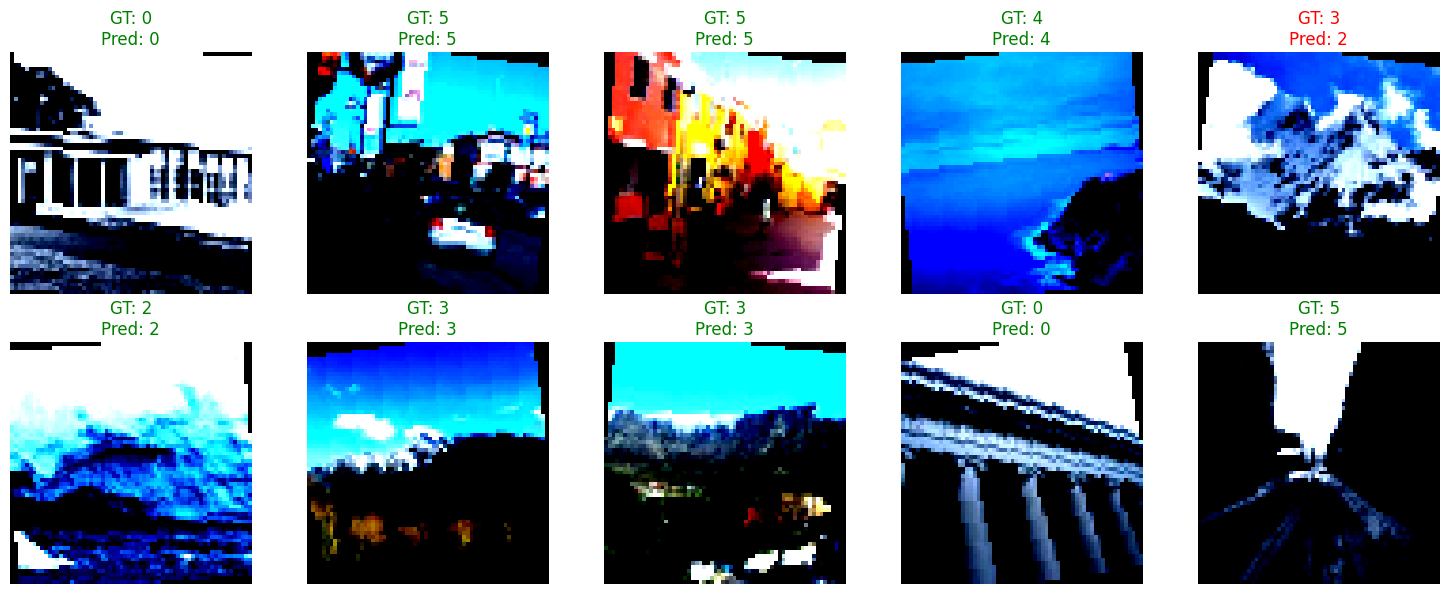

In [ ]:
model.eval()

images, labels = next(iter(val_loader))

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

n = 10
plt.figure(figsize=(15, 6))

for i in range(n):
    plt.subplot(2, n//2, i+1)
    img = images[i].cpu().permute(1, 2, 0)
    plt.imshow(img)

    true_label = labels[i].item()
    pred_label = predicted[i].item()

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"GT: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()